# Connect Four Strategy Analysis

In this notebook, we explore how a rule-based Minimax AI performs against a random agent in Connect Four. We analyze the outcomes of 1000 simulated games to understand patterns in move selection, win rates, and strategic tendencies of the AI.

---

## Step 1: Load Data and Packages

We begin by importing necessary Python packages and loading our simulation dataset, `random_vs_ai.csv`. Each row in the dataset represents a move made during one of the 1000 games.

In [35]:
import pandas as pd
import seaborn as sns
import ast
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [36]:
# Load data 
df = pd.read_csv("random_vs_ai.csv")

# Preview the first few rows
df.head()

,Game,Winner,Move_Num,Player,Move,Board_State
0,1,-1,1,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,-1,2,-1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,-1,3,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,-1,4,-1,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,-1,5,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13592 entries, 0 to 13591
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Game         13592 non-null  int64 
 1   Winner       13592 non-null  int64 
 2   Move_Num     13592 non-null  int64 
 3   Player       13592 non-null  int64 
 4   Move         13592 non-null  int64 
 5   Board_State  13592 non-null  object
dtypes: int64(5), object(1)
memory usage: 637.3+ KB


Game           0
Winner         0
Move_Num       0
Player         0
Move           0
Board_State    0
dtype: int64

---

## Win Distribution

We begin by analyzing the overall outcomes of the games.

- A value of `1` indicates a win by the **Random Player**
- A value of `-1` indicates a win by the **AI Agent**
- A value of `'draw'` indicates a tie

The bar chart below visualizes how many games were won by each type of player.

Win counts:
 Winner
-1    1000
Name: count, dtype: int64


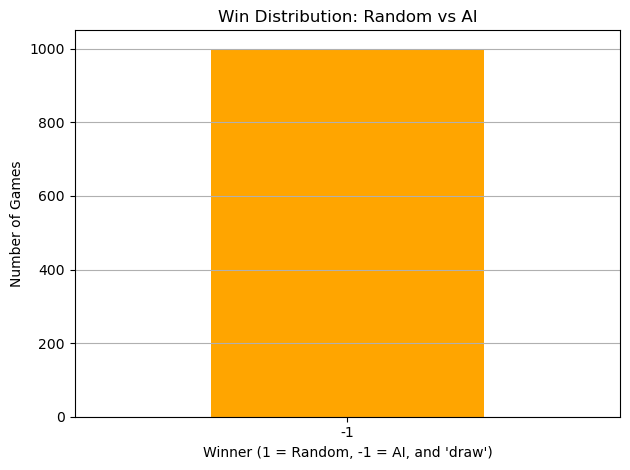

In [46]:
# Group by 'Game' and get the winner for each
game_winners = df.groupby("Game")["Winner"].first()

# Count win types
win_counts = game_winners.value_counts()

# Display raw counts
print("Win counts:\n", win_counts)

# Plot as a bar chart
win_counts.plot(kind='bar', color=["orange", "red", "gray"])
plt.title("Win Distribution: Random vs AI")
plt.xlabel("Winner (1 = Random, -1 = AI, and 'draw')")
plt.ylabel("Number of Games")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

---

## Game Length Analysis

We analyze how long each game lasted by counting the number of moves made per game.

This gives us insight into whether the AI tends to win quickly or if games often reach the maximum number of moves before ending in a draw.

The histogram below shows the distribution of move counts per game.


Move count summary:
count    1000.000000
mean       13.592000
std         4.684387
min         8.000000
25%        10.000000
50%        12.000000
75%        16.000000
max        38.000000
Name: Move_Num, dtype: float64


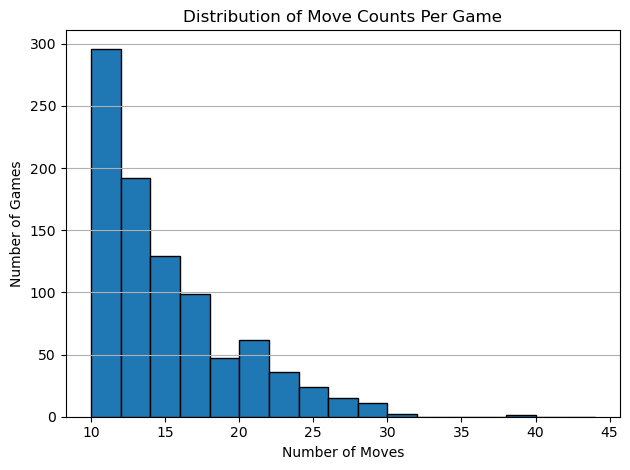

In [39]:
# Count number of moves per game
move_counts = df.groupby("Game")["Move_Num"].max()

# Summary stats
print("Move count summary:")
print(move_counts.describe())

# Plot histogram
plt.hist(move_counts, bins=range(10, 45, 2), edgecolor='black')
plt.title("Distribution of Move Counts Per Game")
plt.xlabel("Number of Moves")
plt.ylabel("Number of Games")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

---

## Column Preference Analysis

Next, we examine which columns are most frequently selected by the Random and AI players.

This can help us visualize patterns like:
- AI prioritizing the center column (column 3)
- Random player having a more even spread

The bar chart (or heatmap) below shows the frequency of moves by column across all games.


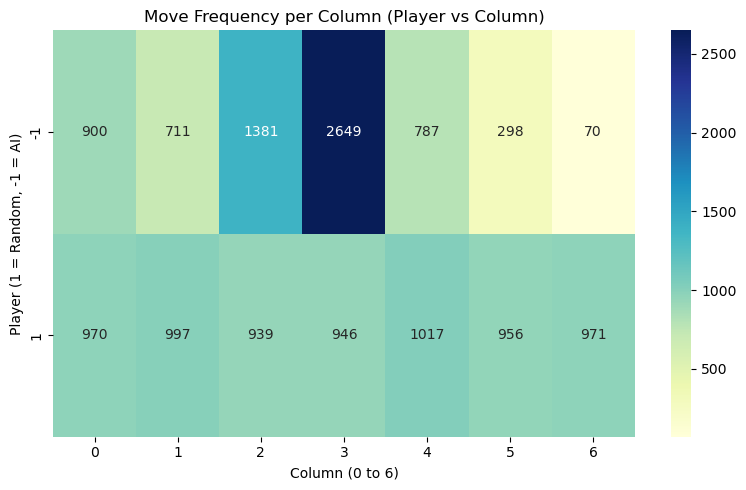

In [40]:
# Count how often each player picks each column
move_freq = df.groupby(["Player", "Move"])["Move"].count().unstack().fillna(0)

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(move_freq, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)
plt.title("Move Frequency per Column (Player vs Column)")
plt.xlabel("Column (0 to 6)")
plt.ylabel("Player (1 = Random, -1 = AI)")
plt.tight_layout()
plt.show()

---

## Move Strategy by Game Stage

To better understand strategic behavior, we categorize moves into three stages:

- **Early Game** (Moves 1–5)
- **Mid Game** (Moves 6–15)
- **Late Game** (Moves 16+)

We then count how often each column is played by each player during these stages. The heatmaps below show the frequency of moves by column and player (1 = Random, -1 = AI) for each game stage.

This allows us to compare how the AI's column preferences evolve throughout a game, and contrast it with the Random agent's behavior.


In [41]:
# Add a new column to categorize move stages
def move_stage(move_num):
    if move_num <= 5:
        return "Early"
    elif move_num <= 15:
        return "Mid"
    else:
        return "Late"

df["Stage"] = df["Move_Num"].apply(move_stage)

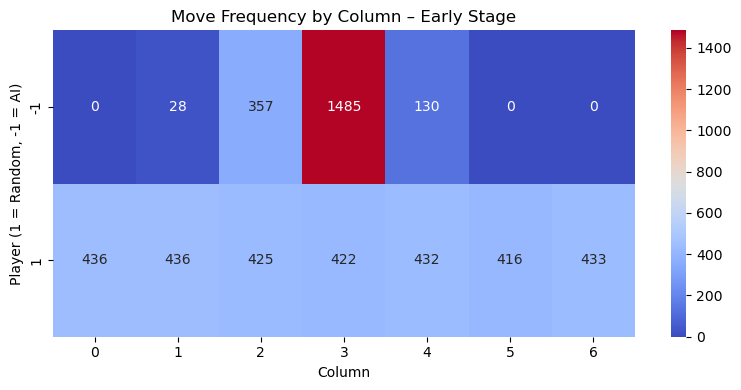

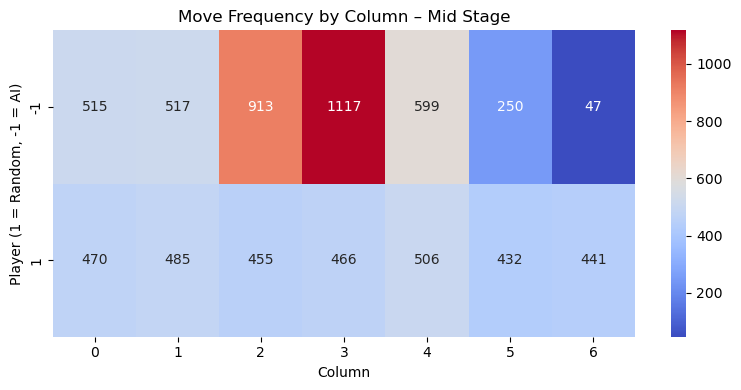

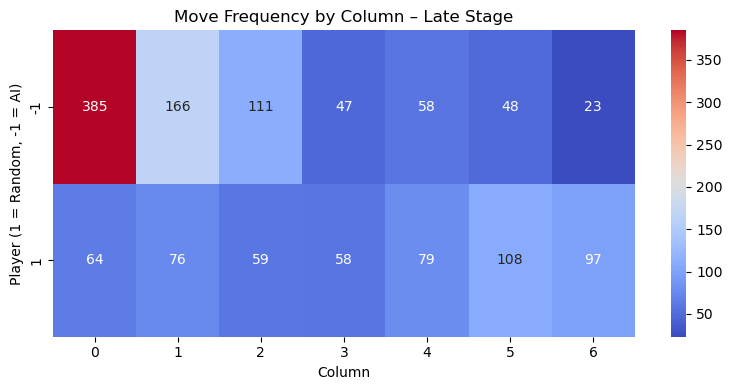

In [42]:
# Count moves per stage, player, and column
stage_counts = df.groupby(["Stage", "Player", "Move"]).size().unstack(fill_value=0)

for stage in ["Early", "Mid", "Late"]:
    plt.figure(figsize=(8, 4))
    sns.heatmap(stage_counts.loc[stage], annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Move Frequency by Column – {stage} Stage")
    plt.xlabel("Column")
    plt.ylabel("Player (1 = Random, -1 = AI)")
    plt.tight_layout()
    plt.show()

---

## Experimental Model Training

Although this project focuses on strategy analysis, we briefly explore the possibility of training a machine learning model to imitate the AI agent's behavior.

### Goal:
Train a classifier that, given the board state, predicts which column the AI will choose.

### Method:
- We extract board states (`X`) and associated move decisions (`y`) from the dataset.
- The board is represented as a flattened vector of 42 values (6 rows × 7 columns).
- We use a Random Forest Classifier to model this decision process.
- Model performance is evaluated using accuracy and classification metrics.

The output below shows the accuracy and precision-recall of the model across the 7 possible column choices.


In [43]:
# Convert the 'Board_State' column from string to list of integers
df['Parsed_Board'] = df['Board_State'].apply(lambda x: np.array(ast.literal_eval(x)))

# Check shape and content of the first row to verify
print("Shape of one board entry:", df['Parsed_Board'].iloc[0].shape)
print("Example board state:\n", df['Parsed_Board'].iloc[0].reshape(6, 7))

Shape of one board entry: (42,)
Example board state:
 [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [44]:
# Extract features and labels
X = np.stack(df['Parsed_Board'].values)
y = df['Move'].values

print("Feature shape:", X.shape)  # Should be (num_samples, 42)
print("Label shape:", y.shape)    # Should be (num_samples,)
print("Example feature (flattened board):", X[0])
print("Example label (move column):", y[0])

Feature shape: (13592, 42)
Label shape: (13592,)
Example feature (flattened board): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Example label (move column): 0


In [45]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,      # number of trees in the forest
    max_depth=10,          # limit depth to prevent overfitting
    random_state=42        # for reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.3872747333578522
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       391
           1       0.30      0.16      0.21       293
           2       0.36      0.44      0.39       463
           3       0.42      0.82      0.56       733
           4       0.33      0.16      0.21       375
           5       0.15      0.03      0.05       236
           6       0.12      0.00      0.01       228

    accuracy                           0.39      2719
   macro avg       0.30      0.28      0.26      2719
weighted avg       0.33      0.39      0.33      2719



---

## Conclusion

This project explored strategic behavior in Connect Four by simulating 1000 games between a Random player and a Minimax AI agent. Through data analysis and visualization, we uncovered key insights:

- The **AI agent consistently outperforms** the random player, confirming the strength of rule-based strategies in deterministic games.
- The **center column** is a dominant early-game target for the AI, suggesting that controlling central positions is critical.
- Games won by AI tend to be shorter on average than drawn or random-won games.
- **Move behavior evolves over time** — the AI tends to diversify column choice as the game progresses, whereas the random player’s behavior remains scattered.

### ML Extension

We also experimented with training a Random Forest model to mimic the AI's move decisions. While the model learned some basic patterns, its performance (~39% accuracy) indicated that:
- The task is challenging without deeper strategic context or feature engineering.
- Board state alone may not be sufficient — outcome-based learning or reinforcement learning might yield stronger performance.

---